In [1]:
!pip install pandas_ta
!pip install neat-python


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [167]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [6]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [8]:
df = pd.read_csv('/tmp/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


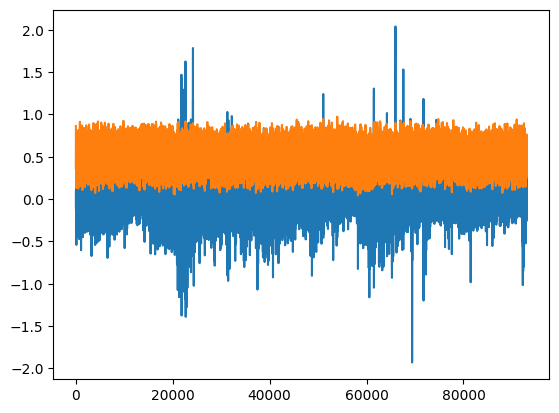

In [9]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [10]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [11]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [12]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [13]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [16]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [232]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     '/tmp/config-feedforward')

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [233]:
winner = p.run(eval_genomes,10)


 ****** Running generation 0 ****** 

Population's average fitness: -26.92108 stdev: 62.79717
Best fitness: 95.72810 - size: (4, 24) - species 1 - id 109
Average adjusted fitness: 0.558
Mean genetic distance 1.288, standard deviation 0.212
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.427 sec

 ****** Running generation 1 ****** 

Population's average fitness: -33.69112 stdev: 41.40994
Best fitness: 45.90561 - size: (4, 24) - species 1 - id 198
Average adjusted fitness: 0.575
Mean genetic distance 1.272, standard deviation 0.241
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.444 sec (2.436 average)

 ****** Running generation 2 ****** 

Population's average fitness: -22.14387 stdev: 37.32843
Best fitness: 43.23865 - size: (4, 24) - species 1 - id 198
Average adjusted fitness: 0.591
Mean genetic distance 1.350, standard deviation 0.255
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.402 sec 

In [234]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [211]:
run_env_loop(net,80000,True)

[1.         0.21895992 0.         0.21895992]
0
[1.         0.17910543 0.1        0.21895992]
0
[1.         0.15917722 0.2        0.21895992]
0
[ 1.         -0.27261123  0.3         0.21895992]
0
[ 1.         -0.46535679  0.4         0.21895992]
0
[1.         0.1994393  0.5        0.21895992]
0
[1.        0.4252869 0.6       0.4252869]
0
[1.         0.23270521 0.7        0.4252869 ]
0
[-1.          1.82626916  0.          1.82626916]
0.23270521286320067
[-1.          0.29947671  0.          0.29947671]
1.8262691584931812
[-1.          0.91250084  0.          0.91250084]
0.29947670938120163
[-1.          0.68699198  0.          0.68699198]
0.9125008408824559
[-1.          0.82794031  0.          0.82794031]
0.686991976774094
[-1.         -0.24703461  0.         -0.24703461]
0.8279403145300622
[-1.          0.04700826  0.          0.04700826]
-0.24703461381697833
[-1.          1.01612639  0.          1.01612639]
0.04700825794571223
[-1.         -0.60193746  0.         -0.60193746]
1.0161

254.1061902065324

In [279]:
node = winner.nodes
conec = winner.connections
values = dict()
count = 0
for index, node in node.items(): 
    values[index] = string.ascii_lowercase[count]
    count += 1
    

In [280]:
key_list = []
weight_list = []
input_dict = dict()

for key, value in conec.items():
       if value.enabled:
            if value.key[0] <0:
                input_var = "P" + str(value.key[0]*-1)
                key_list.append((value.key[1],value.weight,input_var)) 
                              
            else:
                input_var = values[key[1]]
                key_list.append((key[1],value.weight,input_var))
            
                
            

print(key_list)

[(0, -0.8197553078085882, 'P1'), (1, 0.4648820202088311, 'P1'), (2, -0.5053027594429182, 'P1'), (3, 4.109074199639903, 'P1'), (0, -0.4186123055155373, 'P2'), (1, -0.9160362840500864, 'P2'), (2, -0.38938440923085027, 'P2'), (3, 1.997547678457117, 'P2'), (0, -0.755226276140385, 'P3'), (1, -2.5344346446788792, 'P3'), (2, 1.5731128310764462, 'P3'), (3, 0.0557044853058169, 'P3'), (0, 0.9159726136185133, 'P4'), (1, -0.5652042772771583, 'P4'), (3, -1.0755339347366497, 'P4'), (0, -1.1947018885476863, 'P5'), (1, -2.628670648161073, 'P5'), (2, 0.0052943591569435304, 'P5'), (3, -2.1364224076085225, 'P5'), (0, -0.7455548602731408, 'P6'), (1, -0.7787183627765892, 'P6'), (3, 0.3516320216438964, 'P6'), (175, 1.2334969113726972, 'P6'), (3, -0.43813097663385725, 'd')]


In [227]:
print(node)

DefaultNodeGene(key=3, bias=1.5268048091598456, response=1.0, activation=sigmoid, aggregation=sum)


In [244]:


for index, node in node.items():
    neuron_letter = str(values[index]) + " = "
    activation = "AF."+str(node.activation)+"("
    bias = str(node.bias)
    
    
    
    output = neuron_letter + activation
    print(output)

#negative number for connections implies the inputs
#all other numbers implie nodes

AttributeError: 'DefaultNodeGene' object has no attribute 'items'